
# CNN and SVM model and evaluation of features. 
Using the extracted features from create_features_from_PC-GITA.py

### Import stuff

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import LearningCurveDisplay

from functions import *
from possible_data_to_extract import *
from constants import *


2024-01-17 22:43:14.380678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 22:43:14.380702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 22:43:14.381517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 22:43:14.385812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 22:43:14.929136: W tensorflow/compiler/tf2

# Setup for the experiment 

### Ensuring reproducibility in data splitting

In [2]:
seed_number = 42
np.random.seed(seed_number) # To make sure np.random.shuffle() used is reproduceble.

### Choose features

In [3]:
# Choosing which featuers we want to extract // Look in possible_features_to_extract.md to see your choices. 
choosen_features = {}
# My random mix of features
#choosen_features["Articulation"] = ['avg BBEon_1', "avg MFCCon_1"]
#choosen_features["Phonation"] = ['avg Shimmer', 'avg Jitter']
#choosen_features["Prosody"] =  ["avg1Evoiced", "avgEvoiced", "F0avg"] # ["F0avg"]

# All features



choosen_features["Articulation"] = articulation_all_features
choosen_features["Phonation"] = phonation_all_features
choosen_features["Prosody"] = prosody_all_features

# Features used in article 6: 
# choosen_features["Articulation"] = []
# choosen_features["Phonation"] = ['avg Jitter', 'avg Shimmer', 'avg apq', 'avg ppq','std Jitter', 'std Shimmer', 'std apq', 'std ppq', 'skewness Jitter', 'skewness Shimmer', 'skewness apq', 'skewness ppq', 'kurtosis Jitter', 'kurtosis Shimmer', 'kurtosis apq', 'kurtosis ppq']
# choosen_features["Prosody"] = []

# Always bring along the id
choosen_features["Articulation"].append('id') # id is the same for Articulation, Phonation and Prosody so only use one. 

### Choose utterances

In [5]:
# Choosing which data we want to extract // Look in possible_data_to_extract.py to see your choices and import from there. 
# Can use all of one type of data alone, can use different type of data together, can use only one type for for example sentence and etc --> combine as wanted. 

# hc_paths = hc_paths_monologue
# pd_paths = pd_paths_monologue

# Method to use different types of data together: 
#hc_paths = hc_paths_ddk + hc_paths_words + hc_paths_sentences + hc_paths_monologue
# pd_paths = pd_paths_ddk + pd_paths_words + pd_paths_sentences + pd_paths_monologue


# Method to get only some examples out:(can also go to the possible_data_to_extract file and change the values there. 
# hc_paths = [hc_paths[3]]
# pd_paths = [pd_paths[3]]

# Can also be defined here: 
#hc_paths = ["PC-GITA-static-features/sentences/micasa/sin_normalizar/HC", "PC-GITA-static-features/sentences/omar/sin_normalizar/HC" ] # Can also only be one 
#pd_paths = ["PC-GITA-static-features/sentences/micasa/sin_normalizar/PD", "PC-GITA-static-features/sentences/omar/sin_normalizar/PD" ] # Can also only be one

# DDK, words, sentences and monologue: (2000 in total) 
# hc_paths = hc_paths_ddk + hc_paths_monologue + hc_paths_read_text + hc_paths_sentences + hc_paths_sentences2 + hc_paths_words
# pd_paths = pd_paths_ddk + pd_paths_monologue + pd_paths_read_text + pd_paths_sentences + pd_paths_sentences2 + pd_paths_words


# All utterances:
hc_paths = hc_paths_continuous_speech
pd_paths = pd_paths_continuous_speech


base_path = "PC-GITA-static-features" # Folder name for where we have the features saved to
hc_paths = extend_paths(hc_paths, base_path)
pd_paths = extend_paths(pd_paths, base_path)


### Extracting certain data if wanted
If want smaller amount of data from the datatype, for example only vowels of type "A" from vowels we can fix that here

In [6]:

# Choose which data you want to use here
    # for Vowels, add a / first (for ex. /A)
    # If you want all data, use [""]
data_types = [""] # Example: ["/A", "viaje"]  

hc_paths = find_certain_paths_from_all_paths(hc_paths, data_types)
pd_paths = find_certain_paths_from_all_paths(pd_paths, data_types)

print(hc_paths)
print(pd_paths)

print(len(hc_paths))

['PC-GITA-static-features/DDK_analysis/ka-ka-ka/sin_normalizar/hc', 'PC-GITA-static-features/DDK_analysis/pa-pa-pa/sin_normalizar/hc', 'PC-GITA-static-features/DDK_analysis/pakata/sin_normalizar/hc', 'PC-GITA-static-features/DDK_analysis/pataka/sin_normalizar/HC', 'PC-GITA-static-features/DDK_analysis/petaka/sin_normalizar/hc', 'PC-GITA-static-features/DDK_analysis/ta-ta-ta/sin_normalizar/hc', 'PC-GITA-static-features/monologue/sin_normalizar/hc', 'PC-GITA-static-features/read_text/ayerfuialmedico/sin_normalizar/hc', 'PC-GITA-static-features/sentences/laura/sin_normalizar/HC', 'PC-GITA-static-features/sentences/loslibros/sin_normalizar/HC', 'PC-GITA-static-features/sentences/luisa/sin_normalizar/HC', 'PC-GITA-static-features/sentences/micasa/sin_normalizar/HC', 'PC-GITA-static-features/sentences/omar/sin_normalizar/HC', 'PC-GITA-static-features/sentences/rosita/sin_normalizar/HC', 'PC-GITA-static-features/sentences2/1_viste/non-normalized/hc', 'PC-GITA-static-features/sentences2/2_juan

# Data processing 

### Get choosen features

In [7]:
features = {}
features["HC"] = get_features(hc_paths, choosen_features)
features["PD"] = get_features(pd_paths, choosen_features)

    
# display(features["HC"]) 
# display(features["PD"])  # .iloc[150:200]

# print(f" Features used are: {list(features['HC'].keys())}")

### Add metadata 
- Add key for metadata to the features, so that it can be sorted as wanted. 
- Make seperate data for male and female

In [8]:
metadata_path = os.path.join(personal_path_to_PC_GITA,'PCGITA_metadata.xlsx')
metadata = pd.read_excel(metadata_path)

metadata_columns = ["SEX", "AGE", "UPDRS", "UPDRS-speech", "H/Y", "time after diagnosis"]

features["HC"] = add_metadata_columns(features["HC"], metadata, metadata_columns)
features["PD"] = add_metadata_columns(features["PD"], metadata, metadata_columns)

# display(features["PD"])
# display(features["HC"])

metadata_columns.append("id") # Will be used later on to remove all metadata and then also want to remove id. 



# Evaluate the data 

### Find the best features 

In [9]:
def find_x_best_features(f, metadata_columns, x=10):
    """
    Finds the x best features based on the difference between the coefficient of variation (CV) for PD and the CV for HC. 
    Higher difference of CV between the 2 groups gives a higher possibility to separate the classes. 
    
    Note: This is the best features based on the data type used here. 
    
    CV formula gotten from: https://no.wikipedia.org/wiki/Variasjonskoeffisient
    
    Args:
        f (df): DataFrame of features to be plotted. Contains data for both data types. 
        metadata_columns (list): list of the types of metadata we have
        x (int, optional): Number of features we want to consider as the best. Defaults to 10.

    Returns:
        list: List of the x best features
    """
    
    for i in range(len(f)):
        f[i] = f[i].drop(columns=metadata_columns) # Remove metadata columns
    
    feature_types = f[0].keys().to_list()
    f = [np.array(f[0]), np.array(f[1])]

    cv_differences = []
    for i in range(len(feature_types)): # For each feature type
        cv_distance_one_feature = np.abs(np.std(f[0][:,i])/np.abs(np.average(f[0][:,i])) - np.std(f[1][:,i])/np.abs(np.average(f[1][:,i]))) # std_HC/mean_HC - std_PD/mean_PD
        cv_differences.append(cv_distance_one_feature)
    
    ranked_features = [feat for _, feat in sorted(zip(cv_differences, feature_types), reverse=True)] # Sort features by CV differences
    x_best_features = ranked_features[:x] # Select x best features

    return x_best_features

res = find_x_best_features([features["HC"], features["PD"]], metadata_columns, x=10)
print(res)

['avg DDMFCCon_3', 'avg DMFCCoff_7', 'avg DDMFCCon_11', 'kurtosis MFCCon_7', 'avg DDMFCCoff_8', 'avg DMFCCoff_11', 'avg DDMFCCoff_12', 'avg DDMFCCoff_10', 'skewness BBEon_16', 'skewness MFCCon_8']


### Plot features 

In [10]:
def plot_features(f, names, colors, metadata_columns, gaussian = True):
    """
    Plots given features and finds average between all people. 
    Compares features from two different types. For example female vs male or HC vs PD. 
    Both plots feature values vs person number, and a gaussian distribution of these features. 
    
    Note that the amount of features showing on the x axis is only one of the 2 data types (HC vs PD or female vs male),
    so in total we are looking at twice the amount of people. 
    
    Note: len(f) = 2, and every time we iterate through those we look at the 2 data types separately. 

    Args:
        f (df): DataFrame of features to be plotted. Contains data for both data types. 
        names (list): Names of the data types we will be plotting. For example female and male or HC and PD. 
        colors (list): Colors that will be used for the plotting for the 2 data types. 
        metadata_columns (list): list of the types of metadata we have
        gaussian (bool, optional): True or False depending on if you want the gaussian plot as well or not. Defaults to True.
    """
    # Remove metadata columns before plotting all features
    for i in range(len(f)):
        f[i] = f[i].drop(columns=metadata_columns)
    
    feature_types = f[0].keys().to_list()
    f = [np.array(f[0]), np.array(f[1])]
    num_row = [len(f[0]), len(f[1])]

    for i in range(len(feature_types)):
        
        avg = [np.average(f[0][:,i]), np.average(f[1][:,i])]
        std = [np.std(f[0][:,i]), np.std(f[1][:,i])]
        
        print(" ")
        print(f"The average value and std for {feature_types[i]} is: ")
        for j in range(len(f)):
            print(f"   Over the {num_row[j]} {names[j]} the average was {round(avg[j], 2)} and the standard deviation was {round(std[j], 2)}")

        x = [list(range(1, num_row[0] + 1)), list(range(1, num_row[1] + 1))]

        # Plot of features 
        for j in range(len(f)):
            plt.scatter(x[j], f[j][:, i], color=colors[j], label=names[j])
            plt.axhline(y=avg[j], color=colors[j], linestyle='--', label='Avg for ' + names[j])
            plt.axhline(y=avg[j] + std[j], color=colors[j], linestyle=':', label='Std for '+ names[j])
            plt.axhline(y=avg[j] - std[j], color=colors[j], linestyle=':')
            # plt.text(-200, avg[j], np.round(avg[j]), color=colors[j], verticalalignment='bottom')

        plt.plot()
        plt.title(feature_types[i] + ' for different '+ names[0] + ' and ' + names[1], fontsize=18)
        plt.xlabel('Sample nr', fontsize=16)
        plt.ylabel(feature_types[i], fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(loc='upper right', fontsize=14)
        plt.show()
        
        # Note that it is not necessary Gaussian distributed, but assumed it is we can plot the distributions: 
        if gaussian: # Optional to not plot this by defining gaussian = False
            x_range_0 = np.linspace(avg[0] - 3 * std[0], avg[0] + 3 * std[0], 100)
            x_range_1 = np.linspace(avg[1] - 3 * std[1], avg[1] + 3 * std[1], 100)
            plt.plot(x_range_0, norm.pdf(x_range_0, avg[0], std[0]), color=colors[0], linestyle='--', label="Distribution for " + names[0])
            plt.plot(x_range_1, norm.pdf(x_range_1, avg[1], std[1]), color=colors[1], label="Distribution for " + names[1])
            plt.title('Gaussian distributions for feature: ' + feature_types[i], fontsize=18)
            plt.xlabel(feature_types[i] + " values", fontsize=16)
            plt.ylabel('Probability density', fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.legend(loc='upper right', fontsize=14)
            plt.show()

In [11]:
# Define features to plot (ideal to not be all the features we run the model for because that takes some time )
test1 = ['avg F1', 'avg F2', "F0avg", 'avg DF0', 'avg DDF0', 'avg Jitter', 'avg Shimmer', 'avg apq', 'avg ppq', 'F0avg', 'avgEvoiced', 'avgEunvoiced', 'Vrate', 'avgdurvoiced','avgdurpause', 'UVU']
test2 =  ['avg Jitter', 'avg Shimmer', 'F0avg','avg DF0', 'avg DDF0', 'avgdurvoiced', 'avgdurpause']
test3 = ["avg MFCCon_1",  "avg MFCCoff_1", "avg BBEon_1", "avg BBEoff_1", 'avgEvoiced', 'avgEunvoiced']

test4 = ['F0avg','avg DF0']


test5 = ['avg F1', 'avg F2', 'F0avg', 'avg DF0', 'avg DDF0', 'avg apq', 'avg ppq',  'avgdurvoiced','avgdurpause', 'Vrate', 'UVU', 'avgEvoiced', 'avgEunvoiced', ]

test9 =  ['avg Jitter', 'avg Shimmer', 'F0avg','avg DF0', 'avg DDF0', 'avgdurvoiced', 'avgdurpause', "avg F1", "avg F2", "avg ppq", "avg apq"]


features_to_plot_names = ["avgEvoiced","avgEunvoiced" ]   # = [] --> get all features we had. 



features_to_plot = {}
features_to_plot["HC"] = features["HC"].copy()
features_to_plot["PD"] = features["PD"].copy()

if features_to_plot_names:
    features_to_plot["HC"] = features["HC"].loc[:, features_to_plot_names + metadata_columns]
    features_to_plot["PD"] = features["PD"].loc[:, features_to_plot_names + metadata_columns]
    print("Adjusterd the features")
    
    
# Make seperate data for male and female for plotting 
features_male = {}
features_female =  {}

for key in features_to_plot.keys(): 
    features_male[key] = features_to_plot[key][features_to_plot[key]['SEX'] == 'M']
    features_female[key] = features_to_plot[key][features_to_plot[key]['SEX'] == 'F']

# Possible to do data manipulation based on age and the other metadata columns as well. 
    

Adjusterd the features


 
The average value and std for avgEvoiced is: 
   Over the 900 HC the average was -19.95 and the standard deviation was 3.71
   Over the 900 PD the average was -17.94 and the standard deviation was 5.9


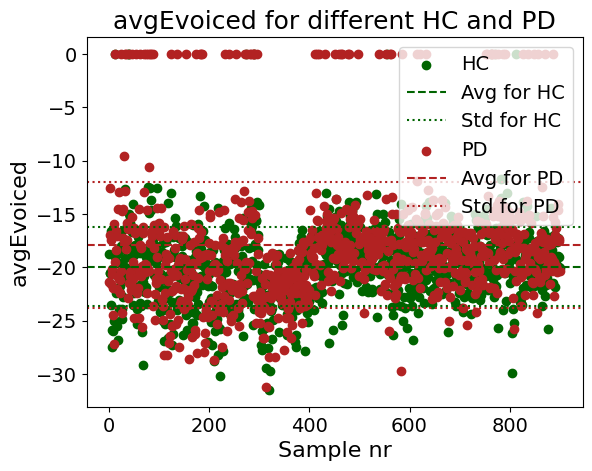

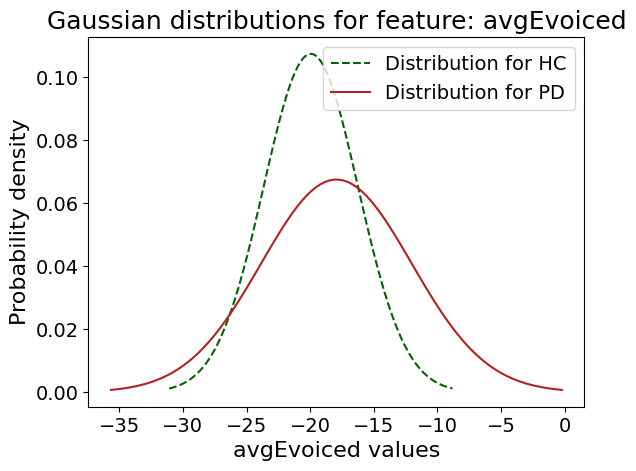

 
The average value and std for avgEunvoiced is: 
   Over the 900 HC the average was nan and the standard deviation was nan
   Over the 900 PD the average was nan and the standard deviation was nan


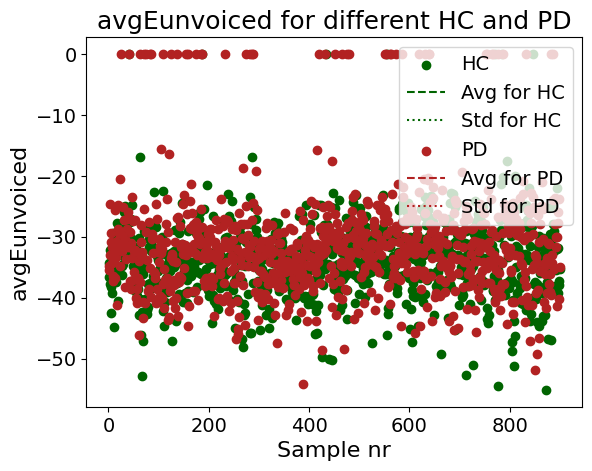

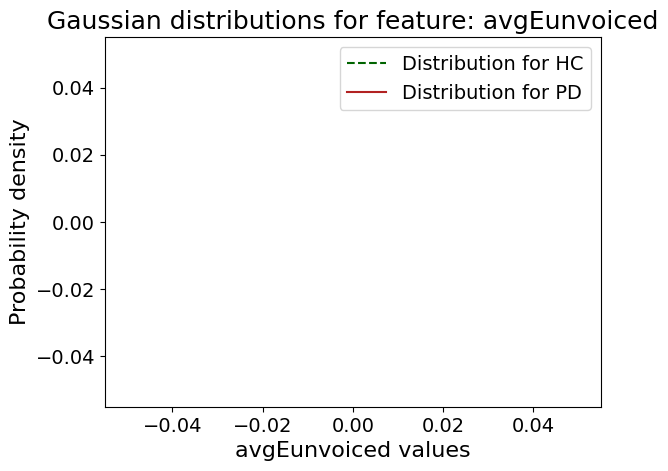

In [12]:
# This plotting works better if you only have one utterance type defined. (t.d one specific vowel/sentence). 
# Not recommended to plot if you have a lot of features, it will take time. 

want_plots = True # Change to True if you want stuff to be plotted. 
if want_plots: 
    # PD vs HC: Shows every utterence type after each other. 
    plot_features([features_to_plot["HC"], features_to_plot["PD"]], ["HC", "PD"], [HC_color, PD_color], metadata_columns)
    # display(features["PD"].loc[0:3])

    # Male vs female: Shows first all healty and then all with PD. 
    features_f = pd.concat([features_female["HC"], features_female["PD"]])
    features_m = pd.concat([features_male["HC"], features_male["PD"]])
    # plot_features([features_f, features_m], ["female", "male"], ["pink", "skyblue"], metadata_columns)

    # PD vs HC for male and female separate: 
    # plot_features([features_female["HC"], features_female["PD"]], ["HC for female", "PD for female"], [HC_color, PD_color], metadata_columns)
    # plot_features([features_male["HC"], features_male["PD"]], ["HC for male", "PD for male"], [HC_color, PD_color], metadata_columns)



In [ ]:
def plot_features_together(f, f_types):
    """
    Plots the 2 features defined in f_types together with the values given from 
    the features list f. 
    
    Note: If both features have 0 as value for the same people then it wont show that there is a lot of 0's,
    but if only one of them has a lot of 0's it will be a clear line of scatters along the 0 line of that feature. 

    Args:
        f (df): DataFrame of all features
        f_types (2 element long list): features to be plotted together
    """
    x = f_types[0]
    y = f_types[1]
    
    plt.scatter(np.array(f["HC"][x]), np.array(f["HC"][y]), color="darkgreen", label="HC")
    plt.scatter(np.array(f["PD"][x]), np.array(f["PD"][y]), color="firebrick", label="PD")

    plt.plot()
    plt.title(f"{x} and {y} for different HC and PD people", fontsize=18)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', fontsize=14)
    plt.show()     

# Only works if we have more than 1 feature to work with, and does not work for the metadata_columns
# feature_types = ["avg BBEon_1", "avg MFCCon_1"]
feature_types = [features["PD"].keys().to_list()[0], features["PD"].keys().to_list()[1]] # Can also use features_to_plot here. 

plot_features_together(features, feature_types)


# Restructure data 

In [9]:
# Usefull if you have a definition of features that is not divided into articulation, phonation and prosody. 
# Choose a smaller amount of features to use: (instead of needing to re run all the code above to change features)
features_for_model =  SoAf_all_mean # Define some features if you want to remove some more features. 

if features_for_model:
    print("HEI")
    features_for_model = features_for_model + metadata_columns
    print(features_for_model)
    features["HC"] = features["HC"].loc[:, features_for_model]
    features["PD"] = features["PD"].loc[:, features_for_model]
    display(features["PD"])

HEI
['avg BBEon_1', 'avg BBEon_2', 'avg BBEon_3', 'avg BBEon_4', 'avg BBEon_5', 'avg BBEon_6', 'avg BBEon_7', 'avg BBEon_8', 'avg BBEon_9', 'avg BBEon_10', 'avg BBEon_11', 'avg BBEon_12', 'avg BBEon_13', 'avg BBEon_14', 'avg BBEon_15', 'avg BBEon_16', 'avg BBEon_17', 'avg BBEon_18', 'avg BBEon_19', 'avg BBEon_20', 'avg BBEon_21', 'avg BBEon_22', 'avg MFCCon_1', 'avg MFCCon_2', 'avg MFCCon_3', 'avg MFCCon_4', 'avg MFCCon_5', 'avg MFCCon_6', 'avg MFCCon_7', 'avg MFCCon_8', 'avg MFCCon_9', 'avg MFCCon_10', 'avg MFCCon_11', 'avg MFCCon_12', 'avg DMFCCon_1', 'avg DMFCCon_2', 'avg DMFCCon_3', 'avg DMFCCon_4', 'avg DMFCCon_5', 'avg DMFCCon_6', 'avg DMFCCon_7', 'avg DMFCCon_8', 'avg DMFCCon_9', 'avg DMFCCon_10', 'avg DMFCCon_11', 'avg DMFCCon_12', 'avg DDMFCCon_1', 'avg DDMFCCon_2', 'avg DDMFCCon_3', 'avg DDMFCCon_4', 'avg DDMFCCon_5', 'avg DDMFCCon_6', 'avg DDMFCCon_7', 'avg DDMFCCon_8', 'avg DDMFCCon_9', 'avg DDMFCCon_10', 'avg DDMFCCon_11', 'avg DDMFCCon_12', 'avg BBEoff_1', 'avg BBEoff_2',

,avg BBEon_1,avg BBEon_2,avg BBEon_3,avg BBEon_4,avg BBEon_5,avg BBEon_6,avg BBEon_7,avg BBEon_8,avg BBEon_9,avg BBEon_10,...,avgdurvoiced,avgdurpause,UVU,SEX,AGE,UPDRS,UPDRS-speech,H/Y,time after diagnosis,id
0,-1.676480,-1.323263,-1.433157,-1.496988,-1.301619,-1.631185,-1.882335,-2.282236,-2.396415,-2.478455,...,0.175714,0.00,0.000000,M,64,28.0,1.0,2.0,3.0,AVPEPUDEA0001_ka.wav
1,-1.098639,-1.016262,-1.600178,-1.678205,-1.968927,-2.297292,-2.288228,-2.718605,-2.616397,-2.646861,...,0.240000,0.16,0.348416,F,72,19.0,0.0,1.0,2.5,AVPEPUDEA0002_ka.wav
2,-1.271929,-0.101187,0.244762,-0.441064,-0.202178,-0.581185,-1.311872,-1.584529,-1.937970,-2.090022,...,0.183333,0.00,0.000000,F,75,52.0,2.0,3.0,3.0,AVPEPUDEA0003_ka.wav
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.543333,0.00,0.000000,M,65,32.0,1.0,2.0,12.0,AVPEPUDEA0005_ka.wav
4,-2.736836,-1.283083,-1.467927,-1.713327,-2.374225,-2.766019,-2.999199,-3.147264,-3.710660,-3.867756,...,0.215000,0.00,0.000000,F,66,28.0,1.0,2.0,4.0,AVPEPUDEA0006_ka.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,M,65,53.0,2.0,2.0,19.0,AVPEPUDEA0055_ta.wav
296,-1.976540,-1.184728,-1.786419,-1.737306,-1.714318,-1.769467,-2.350520,-2.971740,-3.280789,-3.059956,...,0.180000,0.00,0.000000,M,64,45.0,1.0,2.0,3.0,AVPEPUDEA0056_ta.wav
297,-2.637230,-1.390440,-1.841411,-1.963633,-2.149801,-2.458548,-2.346856,-2.722095,-2.916537,-2.404730,...,0.394737,0.00,0.000000,M,68,65.0,2.0,3.0,8.0,AVPEPUDEA0057_ta.wav
298,-2.404725,-1.510197,-2.254860,-2.781557,-2.903649,-2.540038,-3.238658,-3.932731,-4.617941,-4.510109,...,0.156250,0.00,0.000000,M,45,21.0,1.0,1.0,7.0,AVPEPUDEA0058_ta.wav


In [10]:
# Initialize lists to store samples, labels and metadata
values = []
labels = []
metadata = [] 


# Iterate through the feature dictionary
for label, value in features.items():
    metadata.extend(np.array(value[metadata_columns])) # Bring along metadata for future use
    value = np.array(value.drop(columns = metadata_columns))
    values.extend(value)  # Extend the features list with the samples for each label
    num_label = class_labels[label]
    labels.extend([num_label] * len(value))  # Add labels corresponding to each person

# Convert samples and labels to numpy arrays
num_features = len(values[0])
values = np.array(values).reshape(-1, num_features) # Values 
labels = np.array(labels)  # Labels 
metadata = np.array(metadata) # Metadata - to be used to know what data is wrong and correct classified 

# Remove nan values in features. Probably came because of some problem when extracting the features, got a warning with prosody. 
    # When not changing these the SVM model does not work, and the CNN model always predicts HC. 
# print(np.count_nonzero(np.isnan(values))) # Shows how many NaN values we have for each column. 
values = np.nan_to_num(values, nan=0)
labels = np.nan_to_num(labels, nan=0)

print(values.size)

# Testing that the data is the same
# test_nr = 3
# print(features.keys())
# display(values[test_nr])
# display(np.array(features["HC"].loc[test_nr]).reshape(num_features + len(metadata_columns), 1))
# display(metadata[test_nr])


78600


# CNN model

### Train, test, val split

In [ ]:
# Split the data into training, validation, and testing sets (60% training, 20% validation, 20% testing)
# Stratify is used to ensure that each of the new datasets are balanced between PD and HC. 
train_data, temp_data, train_labels, temp_labels, train_metadata, temp_metadata = train_test_split(values, labels, metadata, test_size=0.4, random_state=seed_number, stratify=labels)
val_data, test_data, val_labels, test_labels, val_metadata, test_metadata = train_test_split(temp_data,temp_labels, temp_metadata, test_size=0.5, random_state=seed_number, stratify=temp_labels)

In [ ]:
# Testing that the data has the same length
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
print("  ")
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)
print("  ")
print(train_metadata.shape)
print(test_metadata.shape)
print(val_metadata.shape)

In [ ]:
# Standardize the data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
val_data = scaler.transform(val_data)

### Make the model

In [ ]:
def create_cnn_model1(shape):
    """
    Definition of a cnn model
    Args:
        shape: shape of the input to the model ((2,1) when num_features = 2 )
    Returns:
        model: return the cnn model
    """
    model = models.Sequential([
        layers.Input(shape=shape),
        layers.Conv1D(32, kernel_size=2, padding='same', activation='relu'),
        layers.Conv1D(16, kernel_size=2, padding='same', activation='relu'),
        layers.Conv1D(2 * 256, kernel_size=2, padding='same', activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(2, activation='softmax')  # Output layer with 2 classes
    ])
    return model

In [ ]:
shape = (num_features,1) # values[0].shape  # shape = (num_features,1)
cnn_model = create_cnn_model1(shape=shape)
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary() # Print the model summary

### Fit and predict from the model: 

In [ ]:
# Train the model
history = cnn_model.fit(train_data, train_labels, epochs=40, batch_size=10, validation_data=(val_data, val_labels))

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(test_data, test_labels, verbose=2)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss :.2f}")


### Validate model: 

In [ ]:

# Make predictions on the test set using the model
prediction_scores = cnn_model.predict(test_data)
y_pred = np.argmax(prediction_scores, axis=1)

# Loss and accuracy plots: 
plot_loss_and_accuracy(history=history)

# Calculate and print out confusion matrix
calculate_confusion_matrix(y_true=test_labels, y_pred = y_pred)

# Print out classification report
print_classification_report(y_true=test_labels, y_pred=y_pred)

# Calculate and print sensitivity and specificity 
_ = sensitivity_and_specificity(y_true=test_labels, y_pred = y_pred)

# Print plots and data using metadata
# evaluate_metadata(test_labels=test_labels, y_pred=y_pred, test_metadata=test_metadata, metadata_columns=metadata_columns)

# Plot der curves
# plot_der_curve(test_labels, prediction_scores[:,1])
# plot_der_with_far_and_frr(prediction_scores=prediction_scores)

# Testing the model for some examples using 2 methods:
testing_model_one_example_M1(sample_nr=0, data=features["HC"], true=class_labels["HC"], metadata_columns=metadata_columns, model=cnn_model)
testing_model_one_example_M2(sample_nr=0, data=test_data, labels=test_labels, metadata=test_metadata, model=cnn_model)

# 5 fold cross val: (Without metadata)
x_fold_cross_val(x=values, y=labels, model=cnn_model, num_folds=5, random_state=seed_number, model_type="CNN")

In [ ]:
# Another method to do 5 fold cross val --> look more into
"""
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Initialize the Stratified 5-fold cross-validation
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_number)
# Perform cross-validation and store the accuracy scores
cv_scores = cross_val_score(cnn_model, values, labels, cv=stratified_kf, scoring='accuracy')

# Print the accuracy scores for each fold
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

# Print the mean accuracy across all folds
print(f"\nMean Accuracy: {cv_scores.mean():.4f}")
"""


# SVM

### Training and testing split: 

In [11]:
# Split the data into training and testing sets (60% training, 40% testing)
train_data, test_data, train_labels, test_labels, train_metadata, test_metadata = train_test_split(values, labels, metadata, test_size=0.4, random_state=seed_number, stratify=labels)

# Standardize the data and remove num
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

### Grid search

In [12]:
# Grid search to experiment with different parameters, automatic does cross validation with 5 fold cross val so dont need a validation set. 
kernels = ['rbf', 'linear'] # ['linear', 'rbf', 'poly', 'sigmoid']  # RBF = Gaussian Radial Basis Function 
C = [0.0001, 0.001, 0.1, 1, 10] # [0.1, 1, 10, 100, 1000]
gamma = [0.0001, 0.001, 0.1, 1, 10, 100, 1000] # [1, 0.1, 0.01, 0.001, 0.0001]

In [ ]:
# param_grid = {'C':C, 'gamma':gamma,'kernel': kernels}  Needs to du unnecessary computation for the linear one, method underneath is better. 
param_grid = [{'kernel': ['rbf'], 'gamma': gamma, 'C': C},
        {'kernel': ['linear'], 'C': C}]

grid = GridSearchCV(SVC(random_state=seed_number), param_grid, refit = True, verbose = 3)  # verbose controls how much is printed out, refit = True makes grid be a svm model fitted to the best result from the grid search
grid.fit(train_data, train_labels) 

# print best parameter after tuning 
print(f"The best parameters after grid search is {grid.best_params_}, and therefore now our SVM model: {grid.best_estimator_}") 


In [ ]:
# Evaluation 

train_predictions = grid.predict(train_data)
accuracy_train = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

test_predictions = grid.predict(test_data)
accuracy_test = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")

# Calculate and print out confusion matrix
calculate_confusion_matrix(y_true=test_labels, y_pred = test_predictions)
_ = sensitivity_and_specificity(y_true=test_labels, y_pred = test_predictions)


# Print out classification report
print_classification_report(y_true=test_labels, y_pred=test_predictions)

# Print plots and data using metadata
# evaluate_metadata(test_labels=test_labels, y_pred=test_predictions, test_metadata=test_metadata, metadata_columns=metadata_columns)

# Plotting the decision boundary only works when having a linear kernel, and only makes sense for when we have 2 dimensions of features. 
# feature_types = [features["PD"].keys().to_list()[0], features["PD"].keys().to_list()[1]]
# plot_linear_decision_boundary(grid, test_data, test_labels, test_predictions, feature_types, [HC_color, PD_color])

### Model based on best result from the grid search 

Training Accuracy: 88.61%
Test Accuracy: 82.92%


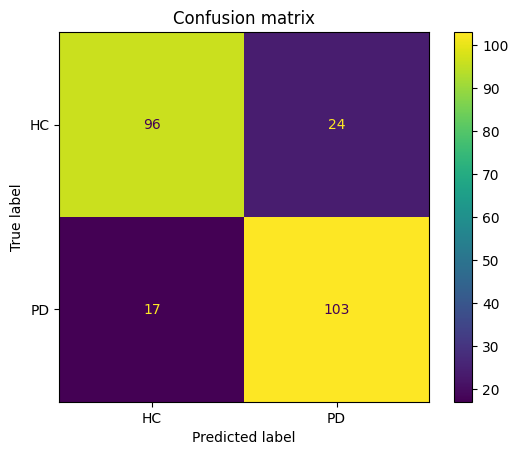

Sensitivity (Recall of PD): 85.83%
Specificity (Recall of HC): 80.00%

Classification Report:
              precision    recall  f1-score   support

          HC       0.85      0.80      0.82       120
          PD       0.81      0.86      0.83       120

    accuracy                           0.83       240
   macro avg       0.83      0.83      0.83       240
weighted avg       0.83      0.83      0.83       240

 
This is data for fold number 1: 
Fold Test Accuracy: 90.00%
Confusion Matrix:
[[27  3]
 [ 3 27]]
 
This is data for fold number 2: 
Fold Test Accuracy: 86.67%
Confusion Matrix:
[[24  6]
 [ 2 28]]
 
This is data for fold number 3: 
Fold Test Accuracy: 80.00%
Confusion Matrix:
[[27  3]
 [ 9 21]]
 
This is data for fold number 4: 
Fold Test Accuracy: 78.33%
Confusion Matrix:
[[23  7]
 [ 6 24]]
 
This is data for fold number 5: 
Fold Test Accuracy: 85.00%
Confusion Matrix:
[[27  3]
 [ 6 24]]
 
This is data for fold number 6: 
Fold Test Accuracy: 83.33%
Confusion Matrix:
[[27

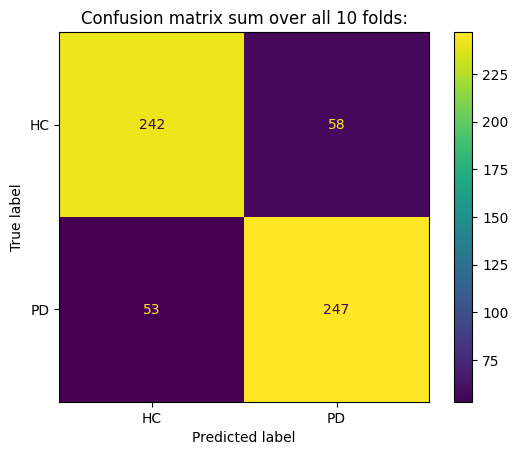

In [12]:
# Model without grid search --> defined to be the best model from the grid search. 
# Gamma is only a kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’, so remove it when linear. 

kernel_best ='rbf' 
C_best = 10
gamma_best = 0.001
svm_model = SVC(kernel=kernel_best, C=C_best, gamma = gamma_best, random_state=seed_number)


svm_model.fit(train_data, train_labels)

train_predictions = svm_model.predict(train_data)
accuracy_train = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

# Testing the model: 
test_predictions = svm_model.predict(test_data)
accuracy_test = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")

# Calculate and print out confusion matrix
calculate_confusion_matrix(y_true=test_labels, y_pred = test_predictions)
_ = sensitivity_and_specificity(y_true=test_labels, y_pred = test_predictions)

# Print out classification report
print_classification_report(y_true=test_labels, y_pred=test_predictions)

# 5 fold cross val for the best chooise of parameters:
x_fold_cross_val(x=values, y=labels, model=svm_model, num_folds=10, random_state=seed_number, model_type ="SVM")


We have 107 women and 92 men in the 199 correctly classified people. 
We have 19 women and 22 men in the 41 wrongly classified people. 


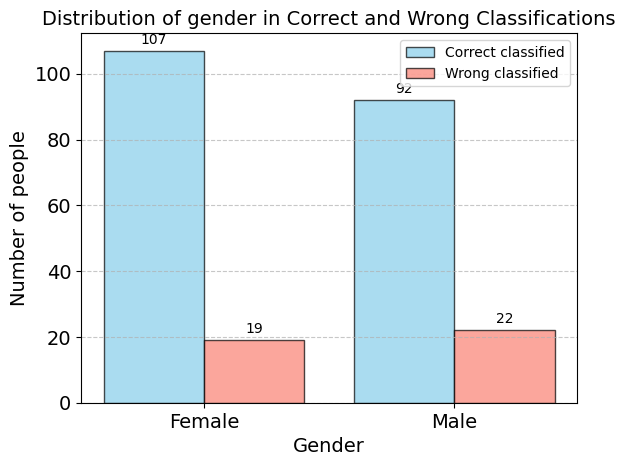

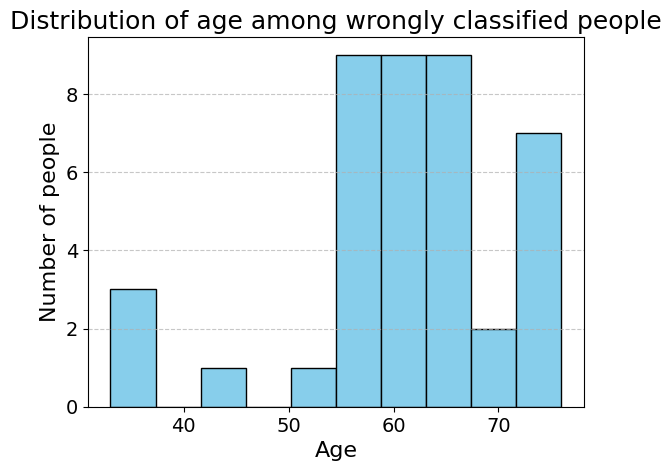

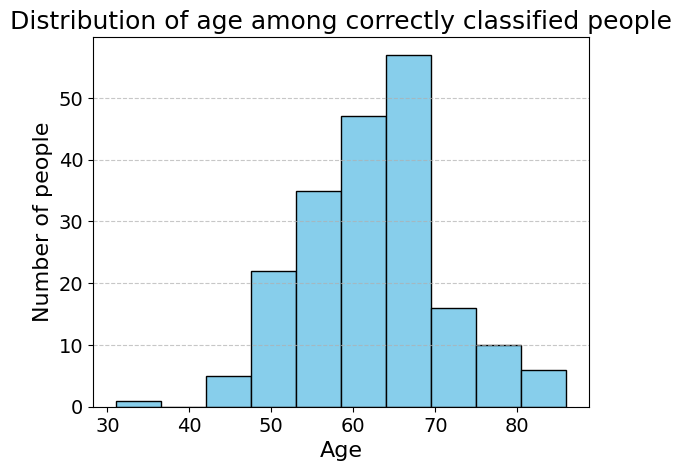

In [13]:
# Print plots and data using metadata
evaluate_metadata(test_labels=test_labels, y_pred=test_predictions, test_metadata=test_metadata, metadata_columns=metadata_columns)

### Learning og validation curves
Based on this: https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

In [ ]:
# # Takes a long time if the data is to large, so nice to test with a smaller portion (like test data). 
    # Run it once for values and labels data (all data), both with linear and rbf kernel. 
svm_eval_model = SVC(kernel='linear', random_state=seed_number)
ValidationCurveDisplay.from_estimator(svm_eval_model, values, labels, scoring='accuracy', param_name="C", param_range=np.logspace(-6, 5, 10))
ValidationCurveDisplay.from_estimator(svm_eval_model, values, labels, scoring='accuracy', param_name="gamma", param_range=np.logspace(-6, 5, 10))
LearningCurveDisplay.from_estimator(svm_model, values, labels, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Test ideal amount of data for the best model: 
LearningCurveDisplay.from_estimator(svm_model, values, labels, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Test best C and gamma 
svm_linear_eval_model = SVC(kernel='linear', random_state=seed_number)
svm_rbf_eval_model = SVC(kernel='rbf', random_state=seed_number)

ValidationCurveDisplay.from_estimator(svm_linear_eval_model, values, labels, scoring='accuracy', param_name="C", param_range=C)

ValidationCurveDisplay.from_estimator(svm_rbf_eval_model, values, labels, scoring='accuracy', param_name="C", param_range=C) # burde eg deffinert ein gamma verdi her? 

ValidationCurveDisplay.from_estimator(svm_rbf_eval_model, values, labels, scoring='accuracy', param_name="gamma", param_range=gamma) # burde eg definert ein C verdi her? 

### Predict the best features 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [ ]:
from sklearn.feature_selection import RFE

feature_names = features["HC"].keys().to_list()
estimator = SVC(kernel="linear") # define it to what I want it to be 
# Initialize RFE
selector = RFE(estimator, n_features_to_select=10, verbose=3) #

# Fit RFE on your data
selector = selector.fit(values, labels)

# Get the selected features
selected_features = [feature for feature, support in zip(feature_names, selector.support_) if support]

# Print the selected features
print(selected_features)

# Models without feature values that are 0 
Skip this for now 

## Reconstruct data and removing 0's
- Remove all feature values that is 0. 
- Make the data in variable length for different people. 
- Add another property that says how many 0's there where. / Test with both this being there and not, does it make a difference?  

To be used in a CNN and SVM network that copes with different length of features in. 

In [ ]:
# MAKE CODE HERE // To add a column for number of 0's ---> remove the 0's later

def add_zero_count_and_exchange_zero_with_none(input_df):
    """
    Count the number of zeros in each row of input dataframe and create a new column with that count. 

    Args:
        input_df (dataframe): Input dataframe we want to add a zero count to. 

    Returns:
        dataframe: Output dataframe with added zero count and replaced 0 values with None
    """
    output_df = input_df.copy()
    output_df.replace(0, None, inplace=True)  # Replace 0 with None so that later when I remove all 0 features I dont remove the zero count even if it is 0. 
    output_df['Zero Count'] = output_df.apply(lambda row: row.tolist().count(None), axis=1)
    return output_df

"""
features_without_zero = {}
features_without_zero["HC"] = add_zero_count_and_exchange_zero_with_none(features["HC"])
features_without_zero["PD"] = add_zero_count_and_exchange_zero_with_none(features["PD"])

display(features_without_zero["HC"])
"""


In [ ]:
def remove_none_values(data):
    """
    Removes None values from each row in the data list
    Note: This function is created with chat GPT. 

    Args:
        data (list): Input list we want to remove None values from

    Returns:
        list: Output list with all None values removed. 
    """
    return [list(filter(lambda x: x is not None, sublist)) for sublist in data]

"""
# Initialize lists to store samples, labels and metadata
values = []
labels = []
metadata = [] 

# Iterate through the feature dictionary
for label, value in features_without_zero.items():
    metadata.extend(np.array(value[metadata_columns])) # Bring along metadata for future use
    value = np.array(value.drop(columns = metadata_columns))
    values.extend(value)  # Extend the features list with the samples for each label
    num_label = class_labels[label]
    labels.extend([num_label] * len(value))  # Add labels corresponding to each person

# Convert samples and labels to numpy arrays
values = remove_none_values(np.array(values))
labels = np.array(labels)  # Labels 
metadata = np.array(metadata) # Metadata - to be used to know what data is wrong and correct classified 

display(values)

# Testing that the data is the same
# test_nr = 1
# print(features.keys())
# display(values[test_nr])
# display(np.array(features["HC"].loc[test_nr]).reshape(num_features + len(metadata_columns), 1))
# display(metadata[test_nr])
"""


In [ ]:
# Split the data into training, validation, and testing sets (60% training, 20% validation, 20% testing)
# Stratify is used to ensure that each of the new datasets are balanced between PD and HC. 
# train_data, temp_data, train_labels, temp_labels, train_metadata, temp_metadata = train_test_split(values, labels, metadata, test_size=0.4, random_state=seed_number, stratify=labels)
# val_data, test_data, val_labels, test_labels, val_metadata, test_metadata = train_test_split(temp_data,temp_labels, temp_metadata, test_size=0.5, random_state=seed_number, stratify=temp_labels)


## SVM model without 0 features 
Try both with and without the zero count variable. 

In [ ]:
# Code here 

# CNN model without 0 features 
Try both with and without the zero count variable. 

In [ ]:
# Code here 